# Datacube Select Methods

Utiliser l'environnement histenv2

## Configuration

### Librairies

In [1]:
import argparse
import logging
from pathlib import Path
import time

import xarray as xr
import numpy as np
import pandas as pd
import intake
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from cstes import labels, zarr_dir

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Parameters

In [3]:
_drop = ["crs","lat_bnds","lon_bnds","ugosa","err_ugosa","vgosa","err_vgosa",
        "ugos","vgos","flag_ice","tpa_correction","nv"]
dl = 0.25
dt = (-2,3)

### Chemin

In [4]:
files = [f"{label}.zarr" for label in labels]
paths = [f"{zarr_dir}/{file}" for file in files]

datacube = Path('/home1/datawork/gcaer/data/aviso/datacube-2019')

## Load colocalisation

In [5]:
number_coloc = 10

In [6]:
while True:
    f = 1.5
    ds_data = xr.open_zarr(paths[10])
    ds_data = ds_data.isel(obs=slice(int(f*number_coloc)))
    ds_data = ds_data.where((ds_data.alti___distance<2e5).compute(), drop=True)

    mask = ((ds_data.box_lon < 178) & (ds_data.box_lon > -178)).all(dim=('box_y', 'box_x'))
    list_obs = ds_data.obs.where(mask.compute(), drop=True).obs
    ds_data = ds_data.sel(obs=list_obs)
    ds_data = ds_data.isel(obs=slice(number_coloc))
    if ds_data.dims['obs'] == number_coloc:
        break
    else:
        f += 0.5

In [7]:
ds_data.dims['obs']

10

## Load datacube

In [8]:
time_chunk = 5
geo_chunk = 150

In [9]:
cat = intake.open_catalog(datacube / "references/aviso/reference.yaml")
ds = cat["data"](chunks={"time": time_chunk, "latitude": geo_chunk, "longitude": geo_chunk}).to_dask()

## Colocalisation

## Méthod 1 : Sequential

In [22]:
times = []
for t in ds_data.time.values:
    times.append([t + pd.Timedelta(days=_dt) for _dt in range(*dt)])

In [23]:
%%time
times, longitudes, latitudes = [],[],[]
extents = []
for i, o in enumerate(ds_data.obs):
    #print(i)
    ds_obs = ds_data.sel(obs=o)
    lon_min = ds_obs.box_lon.min().values
    lon_max = ds_obs.box_lon.max().values
    lat_min = ds_obs.box_lat.min().values
    lat_max = ds_obs.box_lat.max().values
    t = ds_obs.time.values
    ts = [t + pd.Timedelta(days=_dt) for _dt in range(*dt)]
    longitude = np.arange(lon_min - dl, lon_max + dl, dl)
    latitude = np.arange(lat_min - dl, lat_max + dl, dl)
    
    extents.append((lon_min, lon_max, lat_min, lat_max))
    
    times.append(ts)
    longitudes.append(list(longitude))
    latitudes.append(list(latitude))

CPU times: user 948 ms, sys: 992 ms, total: 1.94 s
Wall time: 1.94 s


In [29]:
%%time
result = ds.sel(
    time=xr.DataArray(times,  dims=["obs","t"], coords={'t':[0,1,2,3,4]}),
    longitude=ds_data.box_lon,
    latitude=ds_data.box_lat,
    method="nearest",
).compute()

CPU times: user 42.1 s, sys: 1.23 s, total: 43.3 s
Wall time: 42.1 s


In [30]:
result

<xarray.Dataset>
Dimensions:         (obs: 10, t: 5, box_y: 80, box_x: 120, nv: 2)
Coordinates:
    latitude        (obs, box_y, box_x) float64 -30.12 -30.12 ... 33.62 33.62
    longitude       (obs, box_y, box_x) float64 -43.38 -43.38 ... -49.88 -49.88
  * nv              (nv) int32 0 1
    time            (obs, t) datetime64[ns] 2019-01-01 2019-01-02 ... 2019-01-05
  * t               (t) int64 0 1 2 3 4
  * box_x           (box_x) float64 -3e+05 -2.95e+05 ... 2.9e+05 2.95e+05
  * box_y           (box_y) float64 -2e+05 -1.95e+05 ... 1.9e+05 1.95e+05
    lat             (obs) float64 -26.89 -36.11 31.11 23.36 ... 35.7 32.4 31.08
    lon             (obs) float64 -44.31 -126.9 -66.56 ... -151.1 -71.37 -50.52
  * obs             (obs) int64 1 2 3 4 5 6 7 9 10 11
Data variables: (12/14)
    adt             (obs, t, box_y, box_x) float64 0.7802 0.7802 ... 0.6951
    crs             (obs, t) float64 nan nan nan nan nan ... nan nan nan nan nan
    err_sla         (obs, t, box_y, box_x) float64 0.011 0.011 ... 0.0152 0.0152
    err_ugosa       (obs, t, box_y, box_x) float64 0.0303 0.0303 ... 0.0425
    err_vgosa       (obs, t, box_y, box_x) float64 0.0362 0.0362 ... 0.0604
    flag_ice        (obs, t, box_y, box_x) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    ...              ...
    sla             (obs, t, box_y, box_x) float64 0.1404 0.1404 ... 0.2217
    tpa_correction  (obs, t) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    ugos            (obs, t, box_y, box_x) float64 0.0544 0.0544 ... -0.0571
    ugosa           (obs, t, box_y, box_x) float64 0.0663 0.0663 ... -0.0721
    vgos            (obs, t, box_y, box_x) float64 -0.0457 -0.0457 ... -0.0066
    vgosa           (obs, t, box_y, box_x) float64 -0.0442 -0.0442 ... 0.0029
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    summary:                         SSALTO/DUACS Delayed-Time Level-4 sea su...
    time_coverage_duration:          P1D
    time_coverage_end:               2019-01-01T12:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2018-12-31T12:00:00Z
    title:                           DT merged all satellites Global Ocean Gr...

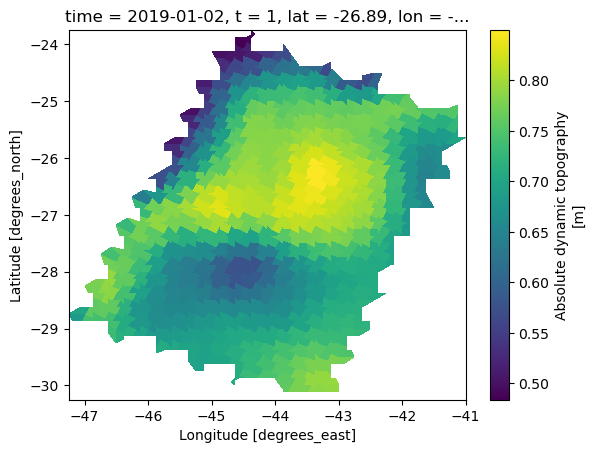

In [31]:
result.sel(obs=1, t=1).adt.plot(x='longitude', y='latitude')

In [120]:
def get_map(obs):
    # Coordonnées lat/lon du rectangle
    lon_min, lon_max, lat_min, lat_max = extents[obs-1]

    # Créer une carte avec Cartopy
    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
    #ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())

    # Définir les coins du rectangle
    corners = [(lon_min, lat_min), (lon_max, lat_min), (lon_max, lat_max), (lon_min, lat_max), (lon_min, lat_min)]

    # Ajouter le rectangle à la carte en reliant les coins
    ax.plot([lon for lon, lat in corners], [lat for lon, lat in corners], color='red', linewidth=2, transform=ccrs.PlateCarree())
    result.sel(obs=obs, t=0).adt.plot(x='longitude', y='latitude', ax=ax, transform=ccrs.PlateCarree(), cmap='viridis', cbar_kwargs={'label': 'Temperature'})
    # Ajouter des caractéristiques de carte supplémentaires
    ax.coastlines()
    ax.gridlines(draw_labels=True)

    # Afficher la carte
    plt.show()

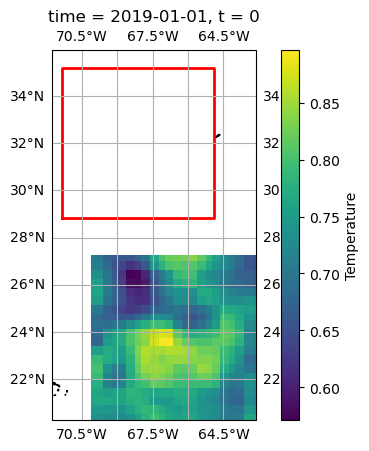

In [119]:
get_map(3)

## Method 2 : Sequential

In [20]:
times = []
for t in ds_data.time.values:
    times.append([t + pd.Timedelta(days=_dt) for _dt in range(*dt)])

In [21]:
%%time
times, longitudes, latitudes = [],[],[]
extents = []
for i, o in enumerate(ds_data.obs):
    #print(i)
    ds_obs = ds_data.sel(obs=o)
    lon_min = ds_obs.box_lon.min().values
    lon_max = ds_obs.box_lon.max().values
    lat_min = ds_obs.box_lat.min().values
    lat_max = ds_obs.box_lat.max().values
    t = ds_obs.time.values
    ts = [t + pd.Timedelta(days=_dt) for _dt in range(*dt)]
    #longitude = np.arange(lon_min - dl, lon_max + dl, dl)
    #latitude = np.arange(lat_min - dl, lat_max + dl, dl)
    #longitude = np.arange(ds_obs.lon - 2, ds_obs.lon + 2, dl)
    #latitude = np.arange(ds_obs.lat - 2, ds_obs.lat + 2, dl)

    longitude = np.linspace(lon_min - dl, lon_max + dl, 20)
    latitude = np.linspace(lat_min - dl, lat_max + dl, 20)
    
    extents.append((lon_min, lon_max, lat_min, lat_max))
    
    times.append(ts)
    longitudes.append(list(longitude))
    latitudes.append(list(latitude))

CPU times: user 1.05 s, sys: 992 ms, total: 2.04 s
Wall time: 2.05 s


In [17]:
%%time
result = ds.sel(
    time=xr.DataArray(times,  dims=["obs","t"]),
    longitude=xr.DataArray(longitudes,  dims=["obs","lon"]),
    latitude=xr.DataArray(latitudes,  dims=["obs","lat"]),
    method="nearest",
).compute()

CPU times: user 2.05 s, sys: 1.14 s, total: 3.19 s
Wall time: 2.19 s


In [18]:
result

<xarray.Dataset>
Dimensions:         (obs: 10, t: 5, lat: 20, lon: 20, nv: 2)
Coordinates:
    latitude        (obs, lat) float32 -30.38 -30.12 -29.88 ... 33.38 33.88
    longitude       (obs, lon) float32 -47.38 -46.88 -46.62 ... -46.12 -45.88
  * nv              (nv) int32 0 1
    time            (obs, t) datetime64[ns] 2019-01-01 2019-01-02 ... 2019-01-05
Dimensions without coordinates: obs, t, lat, lon
Data variables: (12/14)
    adt             (obs, t, lat, lon) float64 0.7497 0.6519 ... 0.5685 0.566
    crs             (obs, t) float64 nan nan nan nan nan ... nan nan nan nan nan
    err_sla         (obs, t, lat, lon) float64 0.0229 0.0228 ... 0.0176 0.0188
    err_ugosa       (obs, t, lat, lon) float64 0.0562 0.0584 ... 0.0487 0.0499
    err_vgosa       (obs, t, lat, lon) float64 0.0688 0.0709 ... 0.0575 0.0562
    flag_ice        (obs, t, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    ...              ...
    sla             (obs, t, lat, lon) float64 0.1105 -0.0056 ... 0.1645 0.1663
    tpa_correction  (obs, t) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    ugos            (obs, t, lat, lon) float64 0.1488 0.3028 ... -0.0601 -0.1053
    ugosa           (obs, t, lat, lon) float64 0.1982 0.299 ... -0.0961 -0.1253
    vgos            (obs, t, lat, lon) float64 0.2131 0.2651 ... -0.0427 0.0032
    vgosa           (obs, t, lat, lon) float64 0.3556 0.2354 ... -0.0224 0.0236
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    summary:                         SSALTO/DUACS Delayed-Time Level-4 sea su...
    time_coverage_duration:          P1D
    time_coverage_end:               2019-01-01T12:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2018-12-31T12:00:00Z
    title:                           DT merged all satellites Global Ocean Gr...

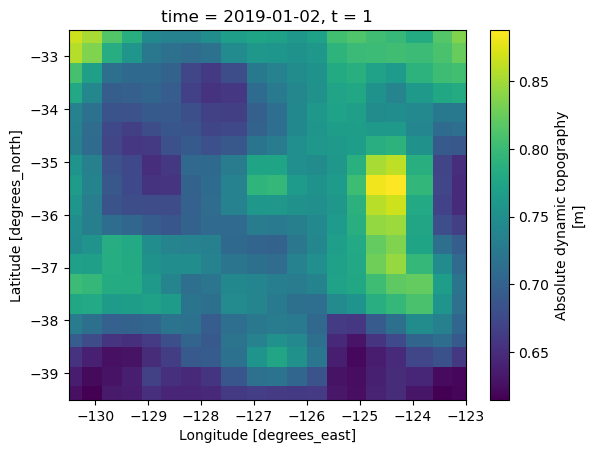

In [100]:
result.sel(obs=1, t=1).adt.plot(x='longitude', y='latitude')

In [101]:
extents[1]

(array(-130.23431812),
 array(-123.34319186),
 array(-39.2084723),
 array(-32.81672917))

In [125]:
def get_map(obs):
    # Coordonnées lat/lon du rectangle
    lon_min, lon_max, lat_min, lat_max = extents[obs]

    # Créer une carte avec Cartopy
    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
    #ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
    ax.set_extent([lon_min - 10, lon_max + 10, lat_min - 10, lat_max + 10], crs=ccrs.PlateCarree())

    # Définir les coins du rectangle
    corners = [(lon_min, lat_min), (lon_max, lat_min), (lon_max, lat_max), (lon_min, lat_max), (lon_min, lat_min)]

    # Ajouter le rectangle à la carte en reliant les coins
    ax.plot([lon for lon, lat in corners], [lat for lon, lat in corners], color='red', linewidth=2, transform=ccrs.PlateCarree())
    result.sel(obs=obs, t=0).adt.plot(x='longitude', y='latitude', ax=ax, transform=ccrs.PlateCarree(), cmap='viridis', cbar_kwargs={'label': 'Temperature'})
    # Ajouter des caractéristiques de carte supplémentaires
    ax.coastlines()
    ax.gridlines(draw_labels=True)

    # Afficher la carte
    plt.show()

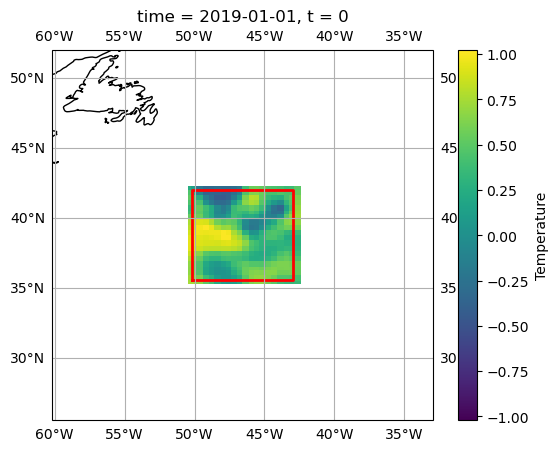

In [126]:
get_map(90)

## Méthod 3 : Vectorized Indexing for Cubes

In [18]:
dt = (-2,3)
nl=50

In [19]:
%%time
lon_mins = ds_data.box_lon.min(dim=['box_x','box_y']).compute()
lon_maxs = ds_data.box_lon.max(dim=['box_x','box_y']).compute()
lat_mins = ds_data.box_lat.min(dim=['box_x','box_y']).compute()
lat_maxs = ds_data.box_lat.max(dim=['box_x','box_y']).compute()

longitudes, latitudes, times = [], [], []
for lon_min, lon_max in zip(lon_mins, lon_maxs):
    longitudes.append(np.linspace(lon_min - dl, lon_max + dl, nl))
for lat_min, lat_max in zip(lat_mins, lat_maxs):
    latitudes.append(np.linspace(lat_min - dl, lat_max + dl, nl))
for t in ds_data.time.values:
    times.append([t + pd.Timedelta(days=_dt) for _dt in range(*dt)])
    
result = ds.sel(
    time=xr.DataArray(times,  dims=["obs","t"], coords={'t':[0,1,2,3,4]}),
    longitude=xr.DataArray(longitudes,  dims=["obs","lon"]),
    latitude=xr.DataArray(latitudes,  dims=["obs","lat"]),
    method="nearest",
).compute()

CPU times: user 1min 37s, sys: 5.01 s, total: 1min 42s
Wall time: 1min 38s


In [20]:
result

<xarray.Dataset>
Dimensions:         (obs: 100, t: 5, lat: 50, lon: 50, nv: 2)
Coordinates:
    latitude        (obs, lat) float64 -30.38 -30.38 -30.12 ... 17.12 17.12
    longitude       (obs, lon) float64 -47.38 -47.12 -47.12 ... 59.62 59.88
  * nv              (nv) int32 0 1
    time            (obs, t) datetime64[ns] 2019-01-01 2019-01-02 ... 2019-01-05
  * t               (t) int64 0 1 2 3 4
Dimensions without coordinates: obs, lat, lon
Data variables: (12/14)
    adt             (obs, t, lat, lon) float64 0.7497 0.7002 ... 0.7331 0.7603
    crs             (obs, t) float64 nan nan nan nan nan ... nan nan nan nan nan
    err_sla         (obs, t, lat, lon) float64 0.0229 0.0245 ... 0.0238 0.0219
    err_ugosa       (obs, t, lat, lon) float64 0.0562 0.0592 ... 0.0995 0.0913
    err_vgosa       (obs, t, lat, lon) float64 0.0688 0.0718 ... 0.101 0.1061
    flag_ice        (obs, t, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    ...              ...
    sla             (obs, t, lat, lon) float64 0.1105 0.0439 ... 0.0655 0.093
    tpa_correction  (obs, t) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    ugos            (obs, t, lat, lon) float64 0.1488 0.2725 ... -0.0606 -0.1803
    ugosa           (obs, t, lat, lon) float64 0.1982 0.2969 ... -0.0732 -0.1856
    vgos            (obs, t, lat, lon) float64 0.2131 0.2925 ... 0.271 0.1926
    vgosa           (obs, t, lat, lon) float64 0.3556 0.3353 ... 0.2671 0.209
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    summary:                         SSALTO/DUACS Delayed-Time Level-4 sea su...
    time_coverage_duration:          P1D
    time_coverage_end:               2019-01-01T12:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2018-12-31T12:00:00Z
    title:                           DT merged all satellites Global Ocean Gr...

In [58]:
ds_data.sel(obs=97).time.values

numpy.datetime64('2019-01-02T15:00:00.000000000')

In [53]:
result.sel(obs=50).time

<xarray.DataArray 'time' (t: 5)>
array(['2019-01-01T00:00:00.000000000', '2019-01-02T00:00:00.000000000',
       '2019-01-03T00:00:00.000000000', '2019-01-04T00:00:00.000000000',
       '2019-01-05T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
    time     (t) datetime64[ns] 2019-01-01 2019-01-02 ... 2019-01-04 2019-01-05
  * t        (t) int64 0 1 2 3 4
Attributes:
    axis:           T
    long_name:      Time
    standard_name:  time

## Méthod 4 : Vectorized Indexing for Points

In [42]:
times = ds_data.time.compute()
longitudes = ds_data.lon.compute()
latitudes = ds_data.lat.compute()

In [43]:
%%time
# Selectionne uniquement les points
result = ds.sel(
    time=times,
    longitude=longitudes,
    latitude=latitudes,
    method="nearest",
).compute()

CPU times: user 26.1 s, sys: 30.9 s, total: 57 s
Wall time: 24.3 s


In [44]:
result

<xarray.Dataset>
Dimensions:         (obs: 10000, nv: 2)
Coordinates:
    latitude        (obs) float32 -26.88 -36.12 31.12 ... 43.12 1.375 53.38
    longitude       (obs) float32 -44.38 -126.9 -66.62 ... 10.38 -6.875 168.6
  * nv              (nv) int32 0 1
    time            (obs) datetime64[ns] 2019-01-03 2019-01-03 ... 2019-01-29
    lat             (obs) float64 -26.89 -36.11 31.11 23.36 ... 43.1 1.31 53.39
    lon             (obs) float64 -44.31 -126.9 -66.56 ... 10.27 -6.91 168.7
  * obs             (obs) int64 1 2 3 4 5 6 ... 12155 12156 12157 12159 12160
Data variables: (12/14)
    adt             (obs) float64 0.8097 0.7294 0.6619 ... 0.0113 0.4537 0.1304
    crs             (obs) float64 nan nan nan nan nan ... nan nan nan nan nan
    err_sla         (obs) float64 0.0201 0.0073 0.0159 ... 0.0173 0.0069 0.0116
    err_ugosa       (obs) float64 0.056 0.0179 0.045 0.0404 ... 0.03 nan 0.0246
    err_vgosa       (obs) float64 0.0528 0.026 0.0465 ... 0.0359 nan 0.0377
    flag_ice        (obs) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    ...              ...
    sla             (obs) float64 0.1809 0.0853 0.062 ... 0.0986 0.1006 -0.004
    tpa_correction  (obs) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    ugos            (obs) float64 0.0555 0.1228 -0.0772 ... 0.0549 -0.0539
    ugosa           (obs) float64 0.01 0.1132 -0.0509 ... -0.0517 0.2545 -0.031
    vgos            (obs) float64 -0.0092 -0.0329 -0.2845 ... -0.0223 0.0802
    vgosa           (obs) float64 -0.0326 -0.04 -0.2659 ... -0.0477 0.0713
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    summary:                         SSALTO/DUACS Delayed-Time Level-4 sea su...
    time_coverage_duration:          P1D
    time_coverage_end:               2015-01-01T12:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2014-12-31T12:00:00Z
    title:                           DT merged all satellites Global Ocean Gr...

## Version 5

In [32]:
ds

<xarray.Dataset>
Dimensions:         (time: 366, latitude: 720, longitude: 1440, nv: 2)
Coordinates:
  * latitude        (latitude) float32 -89.88 -89.62 -89.38 ... 89.62 89.88
  * longitude       (longitude) float32 -179.9 -179.6 -179.4 ... 179.6 179.9
  * nv              (nv) int32 0 1
  * time            (time) datetime64[ns] 2019-01-01 2019-01-02 ... 2020-01-01
Data variables: (12/14)
    adt             (time, latitude, longitude) float64 dask.array<chunksize=(5, 150, 150), meta=np.ndarray>
    crs             (time) float64 dask.array<chunksize=(5,), meta=np.ndarray>
    err_sla         (time, latitude, longitude) float64 dask.array<chunksize=(5, 150, 150), meta=np.ndarray>
    err_ugosa       (time, latitude, longitude) float64 dask.array<chunksize=(5, 150, 150), meta=np.ndarray>
    err_vgosa       (time, latitude, longitude) float64 dask.array<chunksize=(5, 150, 150), meta=np.ndarray>
    flag_ice        (time, latitude, longitude) float64 dask.array<chunksize=(5, 150, 150), meta=np.ndarray>
    ...              ...
    sla             (time, latitude, longitude) float64 dask.array<chunksize=(5, 150, 150), meta=np.ndarray>
    tpa_correction  (time) float64 dask.array<chunksize=(5,), meta=np.ndarray>
    ugos            (time, latitude, longitude) float64 dask.array<chunksize=(5, 150, 150), meta=np.ndarray>
    ugosa           (time, latitude, longitude) float64 dask.array<chunksize=(5, 150, 150), meta=np.ndarray>
    vgos            (time, latitude, longitude) float64 dask.array<chunksize=(5, 150, 150), meta=np.ndarray>
    vgosa           (time, latitude, longitude) float64 dask.array<chunksize=(5, 150, 150), meta=np.ndarray>
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    summary:                         SSALTO/DUACS Delayed-Time Level-4 sea su...
    time_coverage_duration:          P1D
    time_coverage_end:               2019-01-01T12:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2018-12-31T12:00:00Z
    title:                           DT merged all satellites Global Ocean Gr...

Dans la fonction `sel`, le 1er paramètre est l'indexer, il s'agit d'un dictionnaire, où les key représentent les dimensions et les values, représentent: des scalaire, des slices, ou bien des array de 'tick labels'.

In [45]:
ds.sel(
    time=["2019-01","2019-02"],
    longitude=[-20, 20],
    latitude=[-10,10],
    method="nearest",
)

<xarray.Dataset>
Dimensions:         (dim_0: 2, nv: 2)
Coordinates:
    latitude        (dim_0) float32 -9.875 10.12
    longitude       (dim_0) float32 -19.88 20.12
  * nv              (nv) int32 0 1
    time            (dim_0) datetime64[ns] 2019-01-01 2019-02-01
Dimensions without coordinates: dim_0
Data variables: (12/14)
    adt             (dim_0) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    crs             (dim_0) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    err_sla         (dim_0) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    err_ugosa       (dim_0) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    err_vgosa       (dim_0) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    flag_ice        (dim_0) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    ...              ...
    sla             (dim_0) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    tpa_correction  (dim_0) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    ugos            (dim_0) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    ugosa           (dim_0) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    vgos            (dim_0) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    vgosa           (dim_0) float64 dask.array<chunksize=(2,), meta=np.ndarray>
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    summary:                         SSALTO/DUACS Delayed-Time Level-4 sea su...
    time_coverage_duration:          P1D
    time_coverage_end:               2019-01-01T12:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2018-12-31T12:00:00Z
    title:                           DT merged all satellites Global Ocean Gr...

In [39]:
ds.sel(
    {
        'time': slice("2019-01","2019-02"),
        'longitude':slice(-20, 20),
        'latitude':slice(-10,10)
    }
)

<xarray.Dataset>
Dimensions:         (time: 59, latitude: 80, longitude: 160, nv: 2)
Coordinates:
  * latitude        (latitude) float32 -9.875 -9.625 -9.375 ... 9.625 9.875
  * longitude       (longitude) float32 -19.88 -19.62 -19.38 ... 19.62 19.88
  * nv              (nv) int32 0 1
  * time            (time) datetime64[ns] 2019-01-01 2019-01-02 ... 2019-02-28
Data variables: (12/14)
    adt             (time, latitude, longitude) float64 dask.array<chunksize=(5, 80, 110), meta=np.ndarray>
    crs             (time) float64 dask.array<chunksize=(5,), meta=np.ndarray>
    err_sla         (time, latitude, longitude) float64 dask.array<chunksize=(5, 80, 110), meta=np.ndarray>
    err_ugosa       (time, latitude, longitude) float64 dask.array<chunksize=(5, 80, 110), meta=np.ndarray>
    err_vgosa       (time, latitude, longitude) float64 dask.array<chunksize=(5, 80, 110), meta=np.ndarray>
    flag_ice        (time, latitude, longitude) float64 dask.array<chunksize=(5, 80, 110), meta=np.ndarray>
    ...              ...
    sla             (time, latitude, longitude) float64 dask.array<chunksize=(5, 80, 110), meta=np.ndarray>
    tpa_correction  (time) float64 dask.array<chunksize=(5,), meta=np.ndarray>
    ugos            (time, latitude, longitude) float64 dask.array<chunksize=(5, 80, 110), meta=np.ndarray>
    ugosa           (time, latitude, longitude) float64 dask.array<chunksize=(5, 80, 110), meta=np.ndarray>
    vgos            (time, latitude, longitude) float64 dask.array<chunksize=(5, 80, 110), meta=np.ndarray>
    vgosa           (time, latitude, longitude) float64 dask.array<chunksize=(5, 80, 110), meta=np.ndarray>
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    summary:                         SSALTO/DUACS Delayed-Time Level-4 sea su...
    time_coverage_duration:          P1D
    time_coverage_end:               2019-01-01T12:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2018-12-31T12:00:00Z
    title:                           DT merged all satellites Global Ocean Gr...

In [36]:
xr.DataArray(slice("2019-01","2019-02"), dims='obs')

ValueError: different number of dimensions on data and dims: 0 vs 1

In [33]:
ds.sel(
    time=xr.DataArray(slice("2019-01","2019-02"),  dims=["time"]), 
      )

<xarray.Dataset>
Dimensions:         (time: 1, latitude: 720, longitude: 1440, nv: 2)
Coordinates:
  * latitude        (latitude) float32 -89.88 -89.62 -89.38 ... 89.62 89.88
  * longitude       (longitude) float32 -179.9 -179.6 -179.4 ... 179.6 179.9
  * nv              (nv) int32 0 1
  * time            (time) datetime64[ns] 2019-01-01
Data variables: (12/14)
    adt             (time, latitude, longitude) float64 dask.array<chunksize=(1, 150, 150), meta=np.ndarray>
    crs             (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    err_sla         (time, latitude, longitude) float64 dask.array<chunksize=(1, 150, 150), meta=np.ndarray>
    err_ugosa       (time, latitude, longitude) float64 dask.array<chunksize=(1, 150, 150), meta=np.ndarray>
    err_vgosa       (time, latitude, longitude) float64 dask.array<chunksize=(1, 150, 150), meta=np.ndarray>
    flag_ice        (time, latitude, longitude) float64 dask.array<chunksize=(1, 150, 150), meta=np.ndarray>
    ...              ...
    sla             (time, latitude, longitude) float64 dask.array<chunksize=(1, 150, 150), meta=np.ndarray>
    tpa_correction  (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    ugos            (time, latitude, longitude) float64 dask.array<chunksize=(1, 150, 150), meta=np.ndarray>
    ugosa           (time, latitude, longitude) float64 dask.array<chunksize=(1, 150, 150), meta=np.ndarray>
    vgos            (time, latitude, longitude) float64 dask.array<chunksize=(1, 150, 150), meta=np.ndarray>
    vgosa           (time, latitude, longitude) float64 dask.array<chunksize=(1, 150, 150), meta=np.ndarray>
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    summary:                         SSALTO/DUACS Delayed-Time Level-4 sea su...
    time_coverage_duration:          P1D
    time_coverage_end:               2019-01-01T12:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2018-12-31T12:00:00Z
    title:                           DT merged all satellites Global Ocean Gr...

In [18]:
a = ("a", "b", "c", "d", "e", "f", "g", "h")
a[slice(0, 8, 3)]

('a', 'd', 'g')

In [12]:
slice?

Init signature: slice(self, /, *args, **kwargs)
Docstring:     
slice(stop)
slice(start, stop[, step])

Create a slice object.  This is used for extended slicing (e.g. a[0:10:2]).
Type:           type
Subclasses:     

In [14]:
slice('2020-01', '2020-02', '01')

slice('2020-01', '2020-02', '01')